# Combatting Overfitting with Dropout and Regularization

## Preliminaries

In [1]:
# Standard imports
import numpy as np
import torch
import matplotlib.pylab as plt
import copy

#for reproducibility purposes
torch.manual_seed(2025)
np.random.seed(2025)

# Dataset

In [2]:
class DividedPlane(torch.utils.data.Dataset):
    def __init__(self, n=100, noise=0.1, seed=None):
        torch.manual_seed(seed)
        theta = torch.rand((1,))*2.*torch.pi
        a = torch.tensor([torch.cos(theta), torch.sin(theta), 0.1])
        def myfunc(x):
            y = a[0]*x[:,0] + a[1]*x[:,1] + a[2]
            return y
        self.x = torch.rand((n,2))*2. - 1.
        y = myfunc(self.x) + noise*torch.normal( torch.zeros((len(self.x))) )
        self.y = (y>0.).type(torch.float)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def inputs(self):
        return self.x
    
    def targets(self):
        return self.y.reshape( (len(self.y),1) )
    
    def plot(self, labels=None, *args, **kwargs): 
        X = self.inputs()
        if labels is None:
            labels = self.targets()
        colour_options = ['y', 'r', 'g', 'b', 'k']
        if len(labels[0])>1:
            # one-hot labels
            cidx = torch.argmax(labels, axis=1)
        else:
            # binary labels
            cidx = (labels>0.5).type(torch.int)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(X[:,0].detach(), X[:,1].detach(), color=colours, marker='.')


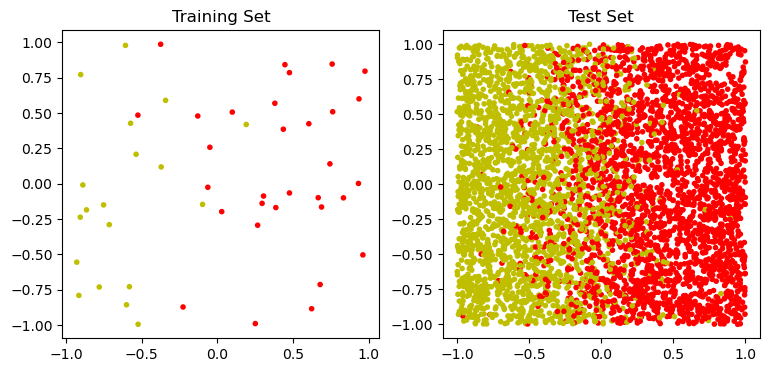

In [3]:
seed = np.random.randint(100000)
train = DividedPlane(n=50, noise=0.3, seed=seed)
test = DividedPlane(n=5000, noise=0.3, seed=seed)
plt.figure(figsize=(9,4))
plt.subplot(1,2,1); train.plot(); plt.title(f'Training Set');
plt.subplot(1,2,2); test.plot(); plt.title(f'Test Set');

# `Dropout` layer

In [ ]:
class Dropout(torch.nn.Module):
    '''
     lyr = Dropout()
     
     Creates a dropout layer in which each node is set to zero
     with probability lyr.dropprob.
     
     Usage:
       lyr = Dropout()
       lyr.set_dropprob(p) # set the dropout probability to p
       y = lyr(z)          # sets each node to 0 with probability p
    '''
    def __init__(self):
        super().__init__()
        self.dropprob = 0.
        
    def set_dropprob(self, p):
        self.dropprob = p
        
    def forward(self, z):
        # Drop nodes with prob dropprob
        if self.training:
            mask = (torch.rand(z.shape) > self.dropprob).float()
            y = mask * z / (1 - self.dropprob)
        else:
            y = z
        return y

In [5]:
# Test for Dropout layer
z = torch.ones((3,1000))
drop_layer = Dropout()
drop_layer.set_dropprob(0.75)
y = drop_layer(z)
drop_fraction = (torch.sum(y==0.)*100.)/torch.numel(y)
print(f'Dropped {drop_fraction:.1f}%')
print(f'Expected output is {torch.sum(y)}, which should be close to {torch.sum(z)}')

Dropped 75.2%
Expected output is 2972.0, which should be close to 3000.0


# `RobustNetwork`

In [6]:
class RobustNetwork(torch.nn.Module):
    def __init__(self, nodes=100):
        super().__init__()
        self.lyrs = torch.nn.ModuleList()
        self.lyrs.append(torch.nn.Linear(2, nodes//2))
        self.lyrs.append(torch.nn.Tanh())
        self.drop_lyr1 = Dropout()
        self.lyrs.append(self.drop_lyr1)
        self.lyrs.append(torch.nn.Linear(nodes//2, nodes))
        self.lyrs.append(torch.nn.Tanh())
        self.drop_lyr2 = Dropout()   
        self.lyrs.append(self.drop_lyr2)  
        self.lyrs.append(torch.nn.Linear(nodes, 1))
        self.lyrs.append(torch.nn.Sigmoid())
        self.loss_fcn = torch.nn.BCELoss(reduction='mean')
    
    def forward(self, x):
        y = x
        for lyr in self.lyrs:
            y = lyr(y)
        return y
    
    def learn(self, x, t, epochs=100, lr=0.1, l2_lambda=0.0):
        losses = []
        for epoch in range(epochs):
            y = self(x)
            loss = self.loss_fcn(y.squeeze(), t.squeeze())

            #Add l2 regulaization implementation here
            l2_penalty = 0.0
            for param in self.parameters():
                l2_penalty += torch.sum(param**2)
            loss += (l2_lambda / 2) * l2_penalty 
            

            losses.append(loss.item())
            self.zero_grad()
            loss.backward()
            with torch.no_grad():
                #replace me for gradient descent updates
                for param in self.parameters():
                    param -= lr * param.grad + lr * l2_lambda * param
        plt.plot(np.array(losses))
        plt.yscale('log'); plt.xlabel('Epochs'); plt.ylabel('Log Loss');

        print(f'Final loss = {loss}')
        return losses
    



# Train and test

In [7]:
net_orig = RobustNetwork(nodes=100)

# Duplicate the network for apples-to-apples comparison
net = copy.deepcopy(net_orig) #network without regularization
dnet = copy.deepcopy(net_orig) #network with dropout
l2net = copy.deepcopy(net_orig) #network with l2 regularization

# Set come common parameters
lr = 0.1
n_epochs = 5000

### Train the models

Final loss = 0.15979363024234772


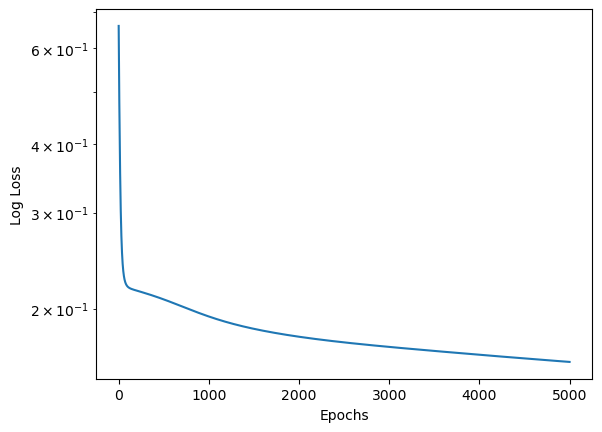

In [8]:
# No effort to guard against overfitting
net.drop_lyr1.dropprob = 0.
net.drop_lyr2.dropprob = 0.
losses = net.learn(train.inputs(), train.targets(), epochs=n_epochs, lr=lr)

Final loss = 0.1674090027809143


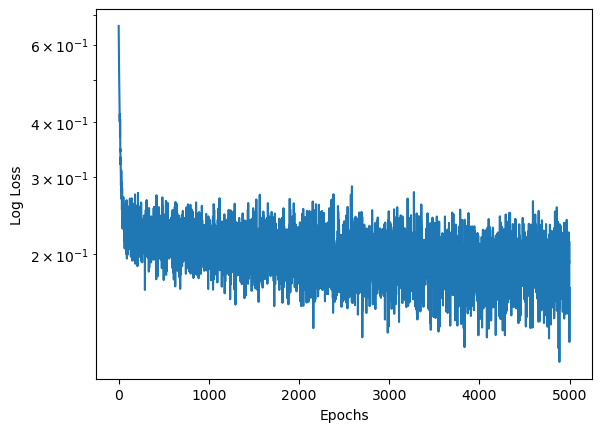

In [9]:
#network with dropout (dnet) training here
dnet.drop_lyr1.set_dropprob(0.2)
dnet.drop_lyr2.set_dropprob(0.2)
dlosses = dnet.learn(train.inputs(), train.targets(), epochs=n_epochs, lr=lr)

Final loss = 0.2697012424468994


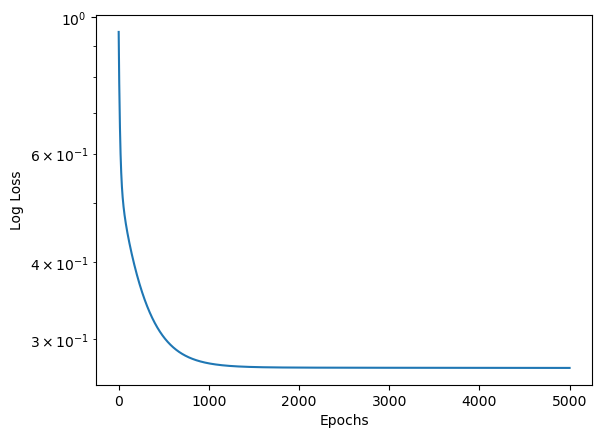

In [10]:
#network with l2 regularization (l2net) training here
l2_lambda = 0.01  # Regularization strength (tunable)
l2net.drop_lyr1.dropprob = 0.
l2losses = l2net.learn(train.inputs(), train.targets(), epochs=n_epochs, lr=lr, l2_lambda=l2_lambda)

### Test the models
#### Let's see what the decision boundaries look like.

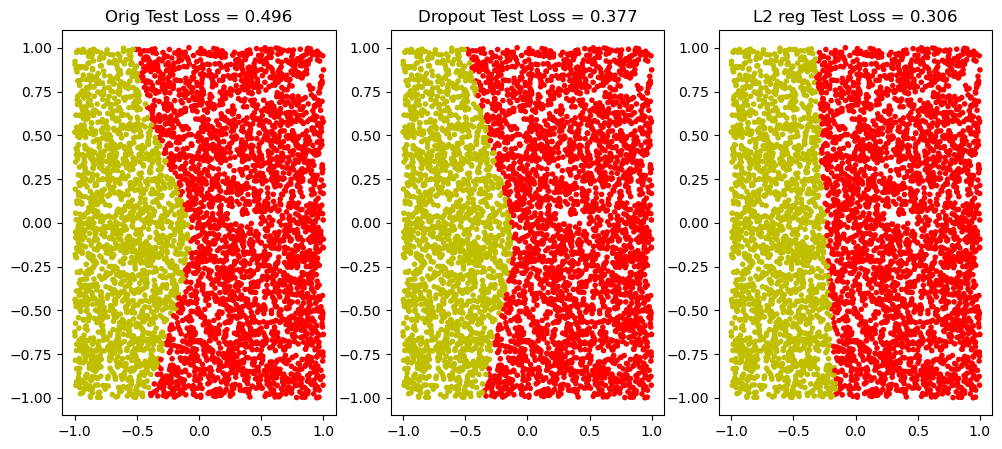

In [11]:
dnet.drop_lyr1.dropprob = 0
dnet.drop_lyr2.dropprob = 0
# Compute test losses here: "test_loss", "dtest_loss", "l2test_loss
test_loss = net.loss_fcn(net(test.inputs()).squeeze(), test.targets().squeeze()).item()
dtest_loss = dnet.loss_fcn(dnet(test.inputs()).squeeze(), test.targets().squeeze()).item()
l2test_loss = l2net.loss_fcn(l2net(test.inputs()).squeeze(), test.targets().squeeze()).item()
# Displaying the results
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
#Original model
test.plot(labels=net(test.inputs())); plt.title(f'Orig Test Loss = {test_loss:.3f}')
plt.subplot(1,3,2)
#Model with dropout
test.plot(labels=dnet(test.inputs())); plt.title(f'Dropout Test Loss = {dtest_loss:.3f}');
plt.subplot(1,3,3)
#Model with L2 regularization
test.plot(labels=l2net(test.inputs())); plt.title(f'L2 reg Test Loss = {l2test_loss:.3f}');

In [12]:

#Share your conclusions here or in Markdown


The regularized test loss is lower than the dropout test loss, which in turn is lower than the original test loss. This occurs because, while the training loss follows the opposite order, regularization helps prevent excessive reliance on large weights, which can significantly impact the outcome. Similarly, dropout reduces the network’s dependency on individual nodes by randomly deactivating some during training, forcing it to distribute learning more evenly. As a result, the original test loss is higher due to overfitting.